# Time Series Anomaly Detection via a GAN-based Reconstruction Model

This notebook demonstrates an approach to **time series anomaly detection** using [TadGAN](https://arxiv.org/abs/2009.07769v3), a time series reconstruction model first developed by researchers at MIT. This model is trained to **closely reconstruct only the non-anomalous parts of a time series**, so that **any divergence from the original series would indicate an anomaly**.

The content of this notebook is created using **an independent implementation of TadGAN in TensorFlow 2**, which enables us to make better use of GPU acceleration and experiment with various modifications.

In this demo, we consider the time series of [NYC taxi passenger](https://github.com/numenta/NAB/blob/master/data/realKnownCause/nyc_taxi.csv) volume from the [Numenta Anomaly Benchmark repository](https://github.com/numenta/NAB). The time series comes with 5 labeled anomalies of known cases -- NYC marathon, Thanksgiving, Christmas, New Year's Day, and a snow storm -- but these labels are **NOT** used in model training, only for evaluation of final results.

Shown in the plot below are the time series, labeled anomalies (blue) and detected anomalies associated to a specific set of hyperparameter values (red). The result has the desired properties of capturing most of the labeled anomalies (**high recall**) without raising too many false alarms (**acceptable precision**).

---

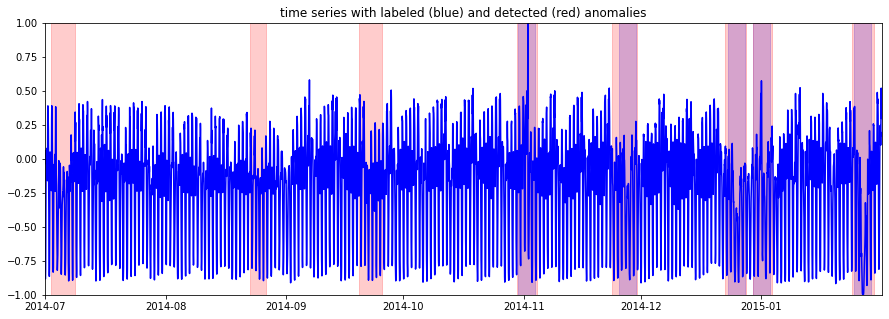

## Imports and Setups

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from tadgan_tf2 import preprocessing, tadgan, postprocessing, utils

In [ ]:
# set constants and hyperparameters

DATASET = 'realKnownCause/nyc_taxi.csv'

# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In this notebook, we source time series data from the [Numenta Anomaly Benchmark repository](https://github.com/numenta/NAB) (downloaded to a local folder in advance). Here we import a time series as a pandas series indexed by numpy datetimes, and its labeled anomalies also as numpy datetimes.

In [ ]:
# import time series

x = pd.read_csv(f'NAB data/{DATASET}')
x['timestamp'] = x['timestamp'].map(np.datetime64)
x = x.set_index('timestamp')['value']

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

Number of time stamps: 10320
First 3 time stamps: 2014-07-01 00:00:00, 2014-07-01 00:30:00, 2014-07-01 01:00:00
Last 3 time stamps: 2015-01-31 22:30:00, 2015-01-31 23:00:00, 2015-01-31 23:30:00


In [ ]:
# import labeled anomalies

with open(f'NAB data/combined_windows.json') as f:
    labeled_intervals = [[np.datetime64(dt) for dt in interval] for interval in json.load(f)[DATASET]]

print(f'Number of labeled anomalous intervals: {len(labeled_intervals)}')

Number of labeled anomalous intervals: 5


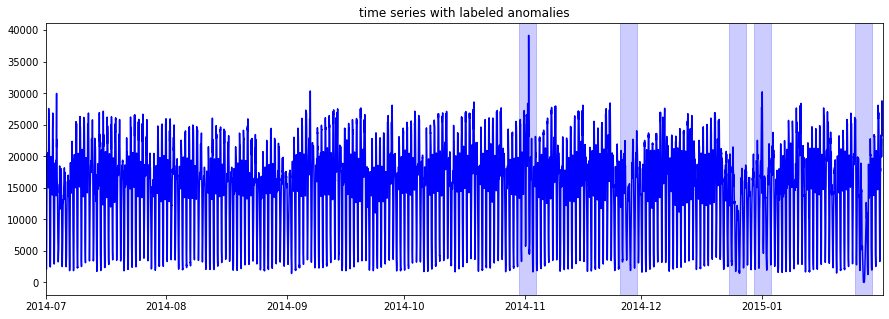

In [ ]:
# plot time series with labeled anomalies

utils.plot_time_series(x.index.to_numpy(), x.to_numpy(), labeled_intervals=labeled_intervals, 
                       title='time series with labeled anomalies')

## Prepare Training Data

To prepare training data for the reconstruction model, we apply to the raw time series a pipeline of preprocessing steps. The main steps are, in order:
- resample the time series at a specified frequency
- rescale values to between -1 and 1
- collect (overlapping) segments of the time series over rolling windows of a fixed specified length (which will be the input dimension of the reconstruction model)



In [ ]:
# apply preprocessing pipeline

x, t, x_win, t_win = preprocessing.apply_pipeline(x, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

In [ ]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 5061
Start times of the first 3 windows: ['2014-07-01T00:00:00.000000000' '2014-07-01T01:00:00.000000000'
 '2014-07-01T02:00:00.000000000']


## Train Reconstruction Model (TadGAN)

[TadGAN](https://arxiv.org/abs/2009.07769v3) is a time series reconstruction model developed by researchers at MIT. The model aims to **closely reconstruct only the non-anomalous parts of time series**, via the interactions of the following components:
- The **encoder** is trained to embed a given collection of time series into normally distributed vectors in a latent space.
- The **generator** is trained to generate time series that resemble the given collection using random vectors in the latent space. 
- The **input space critic** is trained to differentiate between real time series from the given collection and outputs of the generator.
- The **latent space critic** is trained to differentiate between randomly sampled vectors in the latent space and outputs of the encoder.
- In particular, the adversarial goals of the encoder-generator pair and the critics help improve one another (much like other GAN models). 

Here we instantiate a TadGAN model and fit it to the prepared training data. For faster training, in our re-implementation in TensorFlow 2, we have specified the LSTM layers in a way that meets the [requirements of the cuDNN kernel](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).




In [ ]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [ ]:
# train the model

t0 = time.time()
model.fit(x_win, epochs=EPOCHS)
t1 = time.time()

Epoch 1/100 (23.5 secs)
  Critic X Loss: 2.281346 [-1.97185552  0.29911009  0.39540917]
  Critic Z Loss: 3.293125 [-0.19078873  0.8865486   0.25973647]
  Encoder Generator Loss: 0.567492 [-0.27724187 -0.75725649  0.16019905]
Epoch 2/100 (3.7 secs)
  Critic X Loss: -1.734471 [-3.2608196   1.36243695  0.01639114]
  Critic Z Loss: 6.459291 [-0.56174076  5.46753336  0.15534988]
  Encoder Generator Loss: -3.773800 [-1.35538733 -4.92605434  0.25076417]
Epoch 3/100 (3.7 secs)
  Critic X Loss: -1.962820 [-3.43881392  1.28972191  0.01862723]
  Critic Z Loss: -14.050249 [ -0.76194153 -15.82972516   0.25414175]
  Encoder Generator Loss: 19.621481 [-1.29480202 18.50577272  0.24105105]
Epoch 4/100 (3.7 secs)
  Critic X Loss: -2.209876 [-3.58745361  1.16882154  0.02087559]
  Critic Z Loss: -2.962985 [-0.54917427 -3.84814653  0.14343356]
  Encoder Generator Loss: 4.286589 [-1.15393635  3.99251668  0.14480088]
Epoch 5/100 (3.7 secs)
  Critic X Loss: -2.046336 [-4.14735952  1.79596209  0.03050615]
  Cr

In [ ]:
print(f'Total training time for {EPOCHS} epochs: {t1 - t0:.1f} secs')

Total training time for 100 epochs: 421.7 secs


## Generate Reconstructed Time Series

With a trained TadGAN model, we feed the original time series segments (over rolling windows) to the following components of the model:
1. **encoder $\rightarrow$ generator**, which produces **reconstructed versions** of the segments,
2. **input space critic**, which produces **critic scores** of the segments.



In [ ]:
# generate reconstructed time series segments

x_win_recon, critic_scores = model.predict(x_win)

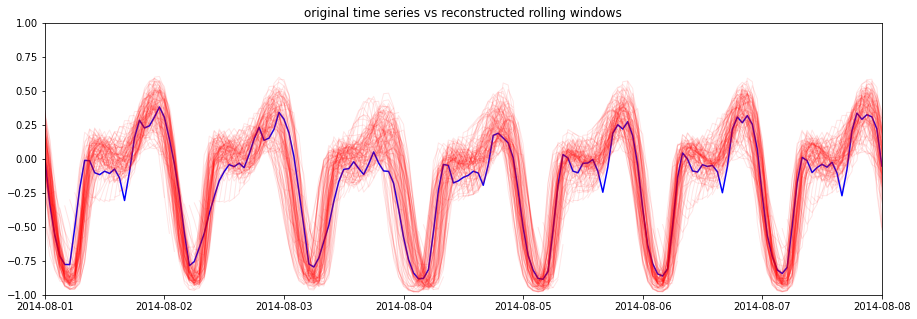

In [ ]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, x, x_win=x_win_recon, 
                       date_range=['2014-08-01', '2014-08-08'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

## Identify Anomalous Intervals

To identify anomalies in the original time series, we apply to the reconstructed segments a pipeline of post-processing steps, similar to those in [this tutorial](https://github.com/signals-dev/Orion/blob/master/notebooks/tulog/Tulog.ipynb). Briefly, these steps include:
- merge the reconstructed segments over rolling windows into a single reconstructed time series
- assign scores to individual time stamps based on reconstruction errors, as measured by local [DTW distances](https://en.wikipedia.org/wiki/Dynamic_time_warping) between the original and reconstructed time series
- transform the critic scores of the original segments over rolling windows into scores associated to individual time stamps
- combine the above two series of scores
- identify extreme values of the combined scores, from either the global or a local perspective

For further details, see documentation in the code.

In [ ]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(x, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

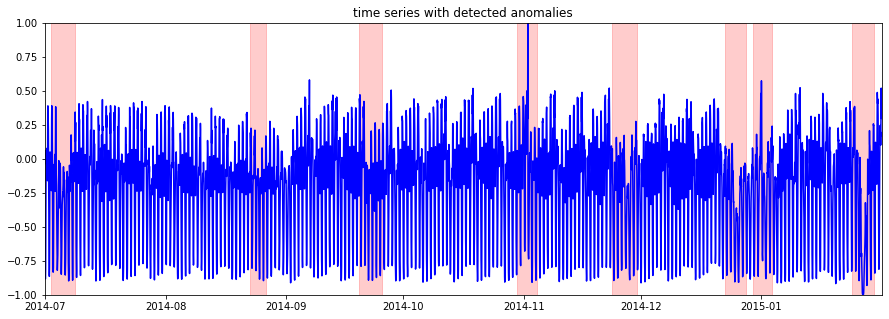

In [ ]:
# plot time series with detected anomalies

utils.plot_time_series(t, x, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

## Evaluate Detected Anomalies

When labeled anomalies are available, we may evaluate the detected anomalies via various metrics. Suppose the role of our detector is to flag issues for further inspection by experts. In this case, it would be desirable to capture as many of the actual anomalies as possible (high recall), but without raising too many false alarms (acceptable precision). For this reason we calculate **recall** and **F1-score** of our result.

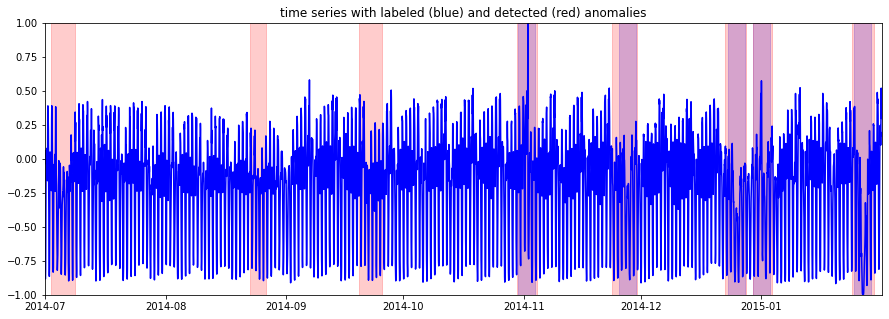

In [ ]:
# plot time series with both labeled and detected anomalies

utils.plot_time_series(t, x, labeled_intervals=labeled_intervals, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with labeled (blue) and detected (red) anomalies')

In [ ]:
# calculate recall and F1 score of detected intervals

recall, _, f1 = utils.evaluate_detected_anomalies(labeled_intervals, detected_intervals)

print(f'Recall : {recall:.3f}')
print(f'F1-score : {f1:.3f}')

Recall : 1.000
F1-score : 0.657
